In [1]:
# import libraries
import pandas as pd
import numpy as np
import re


import matplotlib.pyplot as plt
import matplotlib

import seaborn as sns
from pylab import rcParams
from sklearn.metrics import mean_squared_error, roc_curve, auc
from sklearn.preprocessing import MinMaxScaler
import skfuzzy as fuzz
from sklearn.model_selection import KFold
import QFIE.FuzzyEngines as FE

%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8

In [2]:
import membership
import rule_base
import mamdani
import wangmendel
import defuzz
from Examples.MackeyGlass import synthetic

In [3]:
# 🔹 Carica il dataset (se non è già in memoria)
df = pd.read_csv("./data/relevant_features.csv")
df = df.iloc[:, [0, 1, -1]] 

# 🔹 Seleziona solo le feature di input (senza OUTCOME)
X = df.drop(columns=["OUTCOME"])
y = df["OUTCOME"]

# 🔹 Filtra solo dati normali per training e validation set
df_normal = df[df["OUTCOME"] == 0]
df_anomaly = df[df["OUTCOME"] == 1]

# 🔹 Prendi i primi 9000 dati normali per il training set
X_train = df_normal.iloc[:25000, :-1].values  # Escludi OUTCOME
y_train = df_normal.iloc[:25000, -1].values  # Target

# 🔹 Prendi i successivi 9000 dati normali per il validation set
X_val = df_normal.iloc[9000:18000, :-1].values
y_val = df_normal.iloc[9000:18000, -1].values

X_train = np.vstack((X_train, X_val))
y_train = np.hstack((y_train, y_val))

X_test_5perc = pd.concat([
    df_normal.iloc[19750:23075].drop(columns=["OUTCOME"]), 
    df_anomaly.iloc[1750:1925].drop(columns=["OUTCOME"])
]).values

y_test_5perc = pd.concat([
    df_normal.iloc[19750:23075]["OUTCOME"], 
    df_anomaly.iloc[1750:1925]["OUTCOME"]
]).values

# 🔹 Normalizza con MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(df)  # Ora il numero di feature è coerente
X_train = scaler.fit_transform(X_train)
X_test_5perc = pd.DataFrame(X_test_5perc)
X_test_5perc = scaler.transform(X_test_5perc)

min_values = np.min(X_test_5perc, axis=0)
max_values = np.max(X_test_5perc, axis=0)


# 🔹 Stampa le dimensioni dei dataset
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test_5perc.shape)
print("y_test shape:", y_test_5perc.shape)
print("Numero di etichette 0 in y_test:", np.sum(y_test_5perc == 0))
print("Numero di etichette 1 in y_test:", np.sum(y_test_5perc == 1)) 

X_train shape: (34000, 2)
X_test shape: (3500, 2)
y_test shape: (3500,)
Numero di etichette 0 in y_test: 3325
Numero di etichette 1 in y_test: 175


(34000,)


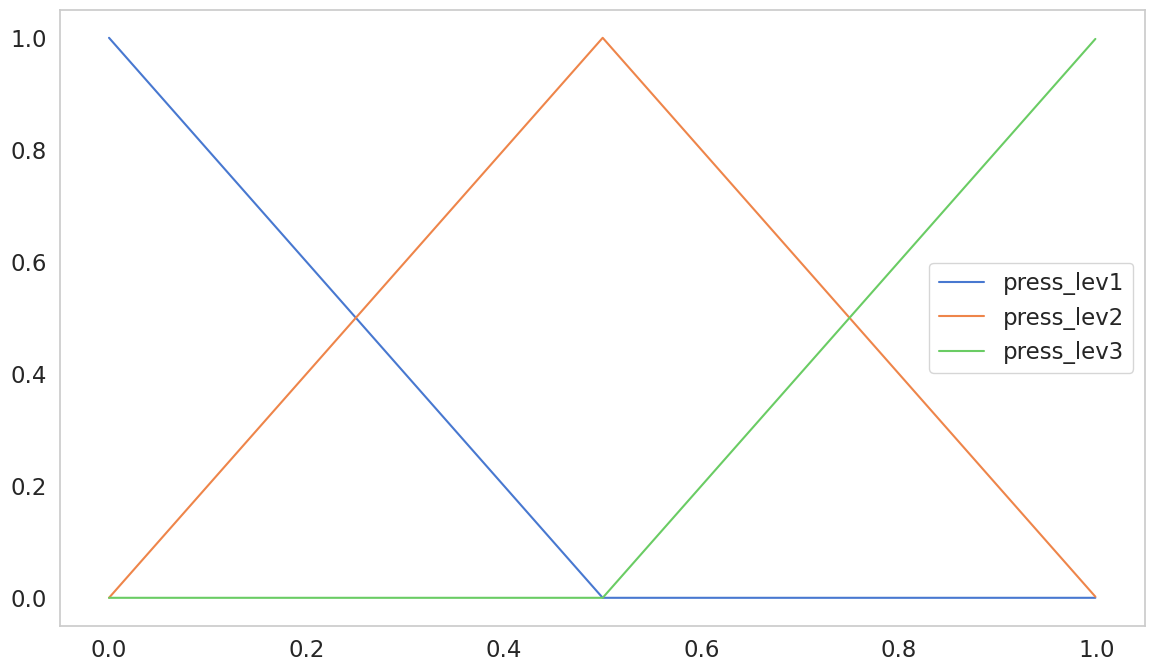

In [34]:
A = np.array(X_train)[:,0]
print(A.shape)

n_regions = 3
name_preffix = 'press_lev'

fuzzy_regions = wangmendel.get_fuzzy_regions(A, n_regions, name_preffix)

# First we need to define the range of values on X-axis
ini = min(A)
end = max(A)

x = np.arange(ini, end, 0.001)

for region in fuzzy_regions:
    pertinence = np.vectorize(region.set.pertinence, otypes=[float])
    plt.plot(x, pertinence(x), label=region.name)
    
plt.legend()
plt.grid()

In [35]:
for region in fuzzy_regions:
    print(region)

press_lev1 = inf_border(x, 0.0, 0.49999999999999956)
press_lev2 = triang(x, 0.0, 0.49999999999999956, 0.9999999999999991)
press_lev3 = sup_border(x, 0.49999999999999956, 0.9999999999999991)


In [ ]:
rule_base = wangmendel.learn_fuzzy_rules(X_train, y_train,
                                        n_regions_inputs=[3,3],
                                        n_regions_output=2,
                                        name_preffix_inputs=['AIT201', 'AIT501', 'UV401', 'P501'],
                                        name_preffix_output='Y')


In [37]:
print("The rule base has {} rules!".format(rule_base.size()))

The rule base has 27200 rules!


In [38]:
rule_base = wangmendel.clean_rule_base(rule_base)
print("The cleaned rule base has {} rules!".format(rule_base.size()))

The cleaned rule base has 273 rules!


In [39]:
rule_list = []
for i in range(rule_base.size()):
    rule_list.append(rule_base.printRule(i))
print(rule_list)

[([['AIT2013', sup_border(x, 0.49999999999999956, 0.9999999999999991)], ['AIT5011', inf_border(x, 0.0, 0.5)]], ['Y1', inf_border(x, 0, 0.0)], 0.842863984275923), ([['AIT2013', sup_border(x, 0.49999999999999956, 0.9999999999999991)], ['AIT5011', inf_border(x, 0.0, 0.5)]], ['Y1', inf_border(x, 0, 0.0)], 0.842863984275923), ([['AIT2013', sup_border(x, 0.49999999999999956, 0.9999999999999991)], ['AIT5011', inf_border(x, 0.0, 0.5)]], ['Y1', inf_border(x, 0, 0.0)], 0.6385180238350283), ([['AIT2013', sup_border(x, 0.49999999999999956, 0.9999999999999991)], ['AIT5011', inf_border(x, 0.0, 0.5)]], ['Y1', inf_border(x, 0, 0.0)], 0.6385180238350283), ([['AIT2013', sup_border(x, 0.49999999999999956, 0.9999999999999991)], ['AIT5011', inf_border(x, 0.0, 0.5)]], ['Y1', inf_border(x, 0, 0.0)], 0.5108250468646965), ([['AIT2012', triang(x, 0.0, 0.49999999999999956, 0.9999999999999991)], ['AIT5013', sup_border(x, 0.5, 1.0)]], ['Y1', inf_border(x, 0, 0.0)], 0.9300003120806517), ([['AIT2012', triang(x, 0.0,

In [40]:
def calculate_reconstruction_error(y_true, y_pred):
    return mean_squared_error(y_true, y_pred)

errors = []
y_pred = []

for x in X_test_5perc:
    y, f_y = mamdani.predict_crisp(x, rule_base)
    predicted_value = defuzz.centroid(y, f_y)
    y_pred.append(predicted_value)
    error = calculate_reconstruction_error([y_test_5perc[len(y_pred) - 1]], [predicted_value])
    errors.append(error)

threshold = np.percentile(errors, 95)
print(f"Threshold for anomaly detection: {threshold}")

# Identificare le anomalie
anomalies = [error > threshold for error in errors]
print(f"Anomalies detected: {sum(anomalies)} out of {len(errors)}")

Threshold for anomaly detection: 0.04999999999972715
Anomalies detected: 175 out of 3500


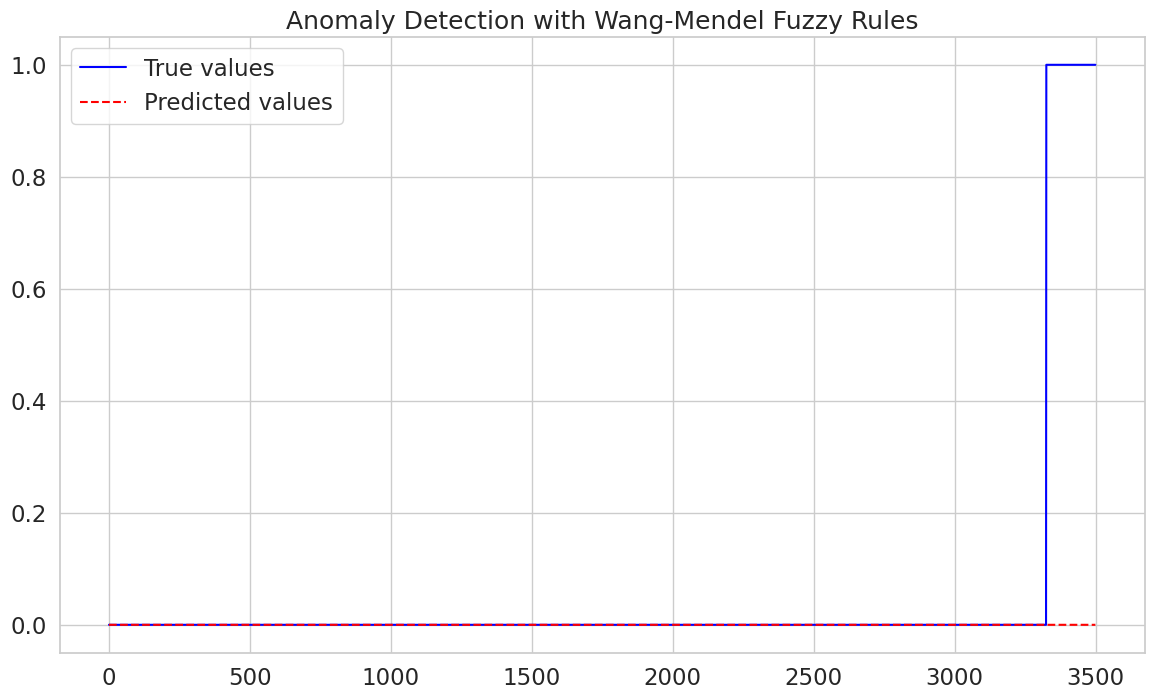

In [41]:
# Plot dei risultati
plt.plot(y_test_5perc, color='blue', label='True values')
plt.plot(y_pred, '--', color='red', label='Predicted values')
plt.legend()
plt.title("Anomaly Detection with Wang-Mendel Fuzzy Rules")
plt.show()


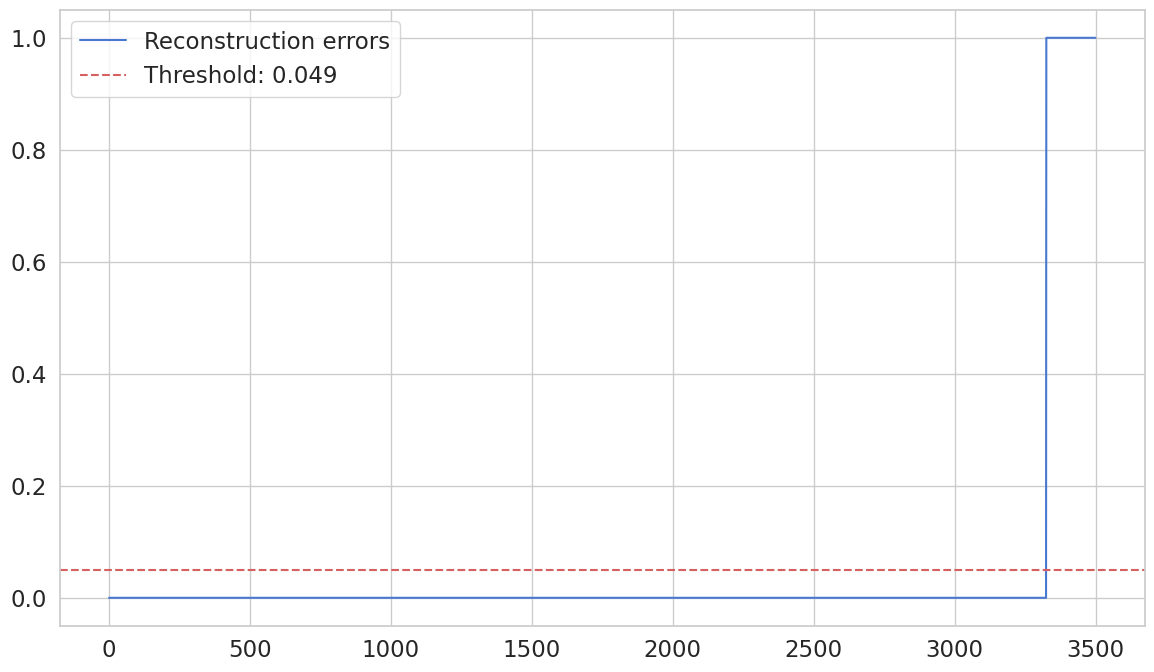

In [42]:
# Mostra le anomalie nel test set
threshold_str = str(threshold)  # Converti in stringa
threshold_str = threshold_str[:threshold_str.find('.') + 4]  # Prendi solo le prime 2 cifre dopo la virgola

plt.plot(errors, label='Reconstruction errors')
plt.axhline(y=threshold, color='r', linestyle='--', label=f"Threshold: {threshold_str}")
plt.legend()
plt.show()

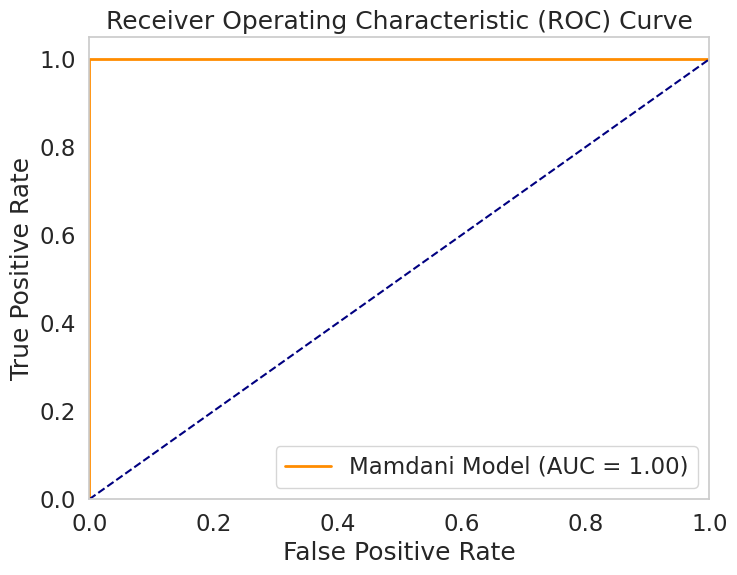

In [43]:
fpr, tpr, _ = roc_curve(y_test_5perc, np.array(errors))
roc_auc = auc(fpr, tpr)

# Disegnare la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Mamdani Model (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')  # Diagonale random classifier
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [ ]:
def map_fuzzy_set_antecedent(fuzzy_set):
        if "triang" in fuzzy_set.__str__():
            return "medium"
        elif "inf_border" in fuzzy_set.__str__():
            return "low"
        elif "sup_border" in fuzzy_set.__str__():
            return "high"

linguistic_rules = []
for antecedent_list, consequent_data, strength in rule_list:
    antecedent_str = " and ".join([f"{var} is {map_fuzzy_set_antecedent(fuzzy_set)}" for var, fuzzy_set in antecedent_list])
    consequent_var, consequent_fuzzy_set = consequent_data
    consequent_str = f"{consequent_var} is normal"
    
    rule_str = f"if {antecedent_str} then {consequent_str}"
    linguistic_rules.append(rule_str)


def remove_last_digit_from_antecedent(rule):
    # Separiamo l'antecedente e il conseguente
    antecedent, consequent = rule.split(' then ')
    # Rimuoviamo l'ultimo numero dai sensori solo nell'antecedente
    antecedent = re.sub(r'(\b[A-Za-z]+\d+)(?=\s)', lambda m: m.group(0)[:-1], antecedent)
    # Ricostruiamo la regola
    return antecedent + ' then ' + consequent

# Applica la funzione a tutte le regole
rules = [remove_last_digit_from_antecedent(rule) for rule in linguistic_rules]
rules = list(set([rule.strip() for rule in rules]))

for rule in rules:
    print(rule)

if AIT201 is medium and AIT501 is medium then Y1 is normal
if AIT201 is medium and AIT501 is low then Y1 is normal
if AIT201 is medium and AIT501 is high then Y1 is normal
if AIT201 is low and AIT501 is low then Y1 is normal
if AIT201 is high and AIT501 is low then Y1 is normal


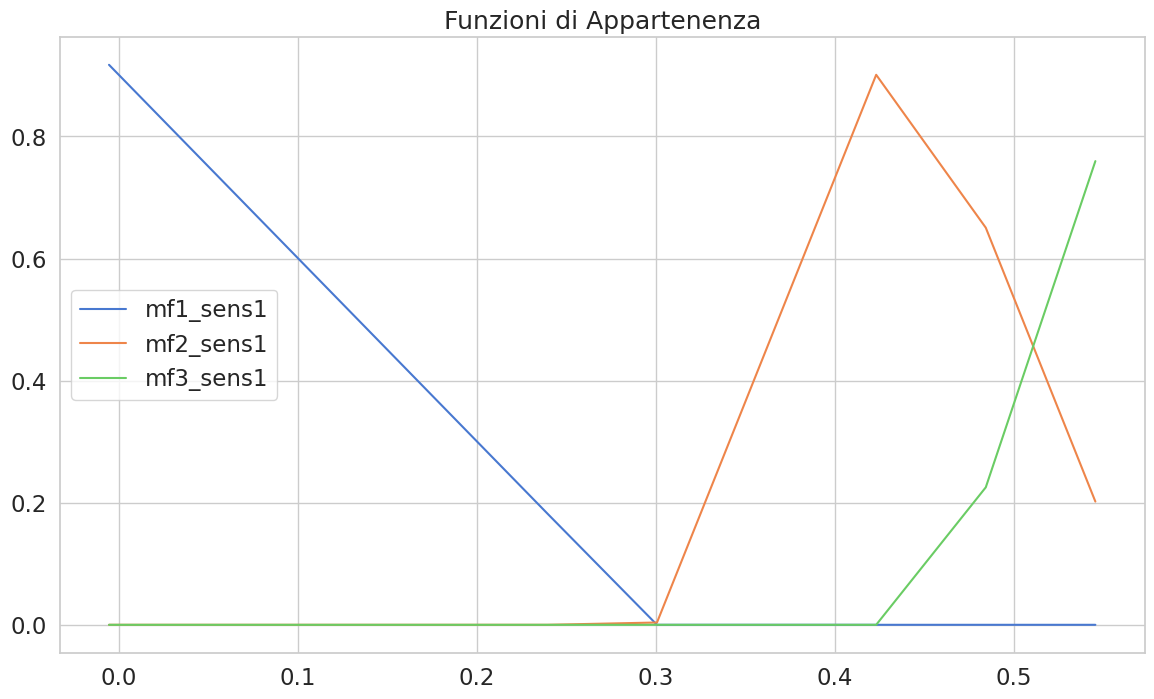

In [40]:
sens_1 = np.linspace(-0.00567416, 0.54546422, 10)
sens_2 = np.linspace(0.04376599, 0.1238632, 10)
Y1 = np.linspace(0, 1, 1)


# Aggiunto un margine del 5% ai valori minimi e massimi
margin_sens1 = 0.05 * (0.54546422 - (-0.00567416))
margin_sens2 = 0.05 * (0.1238632 - 0.04376599)

# Intervalli rilassati per sens_1
a_sens1 = -0.00567416 - margin_sens1
b_sens1 = 0.3  
c_sens1 = 0.54546422 + margin_sens1  

# Intervalli rilassati per sens_2
a_sens2 = 0.04376599 - margin_sens2
b_sens2 = 0.085  
c_sens2 = 0.1238632 + margin_sens2  

# Funzioni di appartenenza per sens_1 (con intervalli rilassati)
mf1_sens1 = fuzz.trimf(sens_1, [a_sens1, a_sens1, b_sens1])  
mf2_sens1 = fuzz.trimf(sens_1, [b_sens1, (b_sens1 + c_sens1) / 2, c_sens1])  
mf3_sens1 = fuzz.trimf(sens_1, [0.8 * c_sens1, c_sens1, c_sens1 + margin_sens1])  

# Funzioni di appartenenza per sens_2 (con intervalli rilassati)
mf1_sens2 = fuzz.trimf(sens_2, [a_sens2, a_sens2, b_sens2])  
mf2_sens2 = fuzz.trimf(sens_2, [b_sens2, (b_sens2 + c_sens2) / 2, c_sens2])  
mf3_sens2 = fuzz.trimf(sens_2, [0.9 * c_sens2, c_sens2, c_sens2 + margin_sens2]) 

mf1_Y1 = fuzz.trimf(Y1, [0, 0, 1])  # [basso, basso, medio] - Normale

# Plot delle membership function
plt.figure()
plt.plot(sens_1, mf1_sens1, label="mf1_sens1")
plt.plot(sens_1, mf2_sens1, label="mf2_sens1")
plt.plot(sens_1, mf3_sens1, label="mf3_sens1")
plt.legend()
plt.title("Funzioni di Appartenenza")
plt.show()


In [ ]:
qfie = FE.QuantumFuzzyEngine(verbose=False)
qfie.input_variable(name='AIT201', range=sens_1)
qfie.input_variable(name='AIT501', range=sens_2) 
qfie.output_variable(name='Y1', range=Y1)
qfie.add_input_fuzzysets(var_name='AIT201', set_names=['low', 'medium', 'high'], sets=[mf1_sens1, mf2_sens1, mf3_sens1])
qfie.add_input_fuzzysets(var_name='AIT501', set_names=['low', 'medium', 'high'], sets=[mf1_sens2, mf2_sens2, mf3_sens2])
qfie.add_output_fuzzysets(var_name='Y1', set_names=['normal'],sets=[mf1_Y1])
rules = [
    'if AIT201 is low and AIT501 is low and UV401 is low and P501 is low then Y1 is normal',
    'if AIT201 is high and AIT501 is low and UV401 is low and P501 is low then Y1 is normal',
    'if AIT201 is medium and AIT501 is high and UV401 is low and P501 is low then Y1 is normal',
    'if AIT201 is medium and AIT501 is medium and UV401 is low and P501 is low then Y1 is normal',
    'if AIT201 is medium and AIT501 is low and UV401 is low and P501 is low then Y1 is normal',
    'if AIT201 is low and AIT501 is low and UV401 is low and P501 is low then Y1 is normal'
]
qfie.set_rules(rules)

In [ ]:
f_quantum = []

for row in X_test_5perc: 
    input_values = {
        'AIT201': row[0],
        'AIT501': row[1]
    }
    
    i = 0
    # Costruct Quantum Circuit for Inference
    qfie.build_inference_qc(input_values, draw_qc=True, filename=f"q_rules/circuit_{i}.png")
    i = i + 1
    
    # Quantum Inference
    f_quantum.append(qfie.execute(n_shots=1000, plot_histo=True)[0])

draw


KeyboardInterrupt: 